## Rakeshwer's Master Thesis 2022: 

### "Time Series Prediction with ANNs on non-linear and non-stationary Time Series"

**Idea:**

Inspired by promising results from experiments in notebooks 02 and 03, we now try to put our focus on practical issues and try to **set up a working trading model**.

**Outline:**

Try again to predict 11 models on SP500 and VIX close (rel. chg.) as *two* input features and use SP500 close (rel. chg.) as target with horizon 20d:
- What accuracy do we reach, if we use UP / DOWN as majority vote from all 11 model predictions (UP: At least 6 models predict an UP movement, DOWN: else)?
- Better or worse than random guessing?

Then proceed to train a FULL model in a TWO STEP process:
- Train and store 11 models on SP500 close (rel. chg.) input samples of length 20d on SP500 close (rel. chg.) target with horizon 20d. Then:
 - Get an ensemble predictor to create a continuous target with discrete values: "number of correct predictions".
 - Also create a binary ensemble predictor HIGH / LOW reliability from number of correct predictions (HIGH: At least 6 models' prediction was pointing in the right direction, LOW: else). --> This is only used for visualization of partitioning to show that there are indead *regimes* where model predictions work better or worse. On average, the prediction accuracy is poor, compared to random guessing.
 - And derive a binary ensemble predictor UP / DOWN as majority vote from all 11 model predictions (UP: At least 6 models predict an UP movement, DOWN: else). --> This is only used for visualization of HOW we would act, if final model classifies VIX sample as HIGH reliable.
- Train and store another 11 models on VIX close (rel. chg.) input samples of length 20d on continuous target "number of correct predictions".
- Derive a binary prediction to classify VIX samples a HIGH / LOW reliable, according to predicted number of correct predictions (HIGH: Prediction is greater or equal to 6, LOW: else). --> This actually tells us, WHERE we act, according to binary ensemble predictor UP or DOWN.
- Check accumulated profits for different strategies:
 - Act only on HIGH-reliability spots and then ALWAYS go LONG.
 - Act only on HIGH-reliability spots but according to ensemble predictor: UP or DOWN.
 - Naive buy and hold-strategy: Act always and always LONG.

### Tech Preamble

In [1]:
import sys
import datetime
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed, Input, Dense, Conv1D, Conv2D, AveragePooling1D, MaxPooling1D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, GaussianNoise, LeakyReLU
from tensorflow.keras.layers import concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adagrad, Nadam, RMSprop, schedules
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.datasets as tfds
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

### Import data

In [2]:
# Define path to data folder:
path_to_data = "../data"

# Import data from csv file:
data = np.genfromtxt(join(path_to_data,'sp500_vix.csv'), delimiter=';', skip_header=1)

In [3]:
# Check dimensions:
print("data shape (samples, features): ", data.shape)
print("\nfirst row: \n", data[0])

print("\nfeatures [column number]:")
print("=========================")
print("[0] - year")
print("[1] - sp500 close (abs)")
print("[2] - sp500 close (rel chg)")
print("[3] - vix close (abs)") 
print("[4] - vix close (rel chg)")
print("[5] - target 1d (rel chg)")
print("[6] - target 5d (rel chg)")
print("[7] - target 10d (rel chg)")
print("[8] - target 20d (rel chg)")

data shape (samples, features):  (8218, 9)

first row: 
 [ 1.9900000e+03  3.5876000e+02 -2.5855600e-03  1.8190001e+01
  5.5104466e-02 -8.6130000e-03 -3.1915487e-02 -5.9538410e-02
 -8.2729401e-02]

features [column number]:
[0] - year
[1] - sp500 close (abs)
[2] - sp500 close (rel chg)
[3] - vix close (abs)
[4] - vix close (rel chg)
[5] - target 1d (rel chg)
[6] - target 5d (rel chg)
[7] - target 10d (rel chg)
[8] - target 20d (rel chg)


In [4]:
# Extract year for seperating data into train / validation / test sets
year = data[:,0]

## Extract sp500 and vix close (rel chg) as input features.
# [2] - sp500 close (rel chg) 
# [4] - vix close (rel chg)

inputs = data[:,(2,4)]

## Extract target values for 1d / 5d / 10d / 20d as rel chg:
# [5] - target 1d (rel chg)
# [6] - target 5d (rel chg)
# [7] - target 10d (rel chg)
# [8] - target 20d (rel chg)

targets = data[:,5:]

# Check dimensions:
print("year shape (samples): ", year.shape)
print("inputs shape (samples, input features): ", inputs.shape)
print("targets shape (samples, output features): ", targets.shape)

year shape (samples):  (8218,)
inputs shape (samples, input features):  (8218, 2)
targets shape (samples, output features):  (8218, 4)


### Define function to split data, custom loss and evaluation metrics

In [5]:
# Define function to split time series 'sequence' into 'n_steps'
def split_sequence(sequence, n_steps):
    X = list()
    for i in range(len(sequence)):
        # Find the end of this pattern
        end_ix = i + n_steps
        # Check if we are beyond the sequence
        if end_ix > len(sequence):
            break
        # Gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return np.array(X)

### Define functions for CNN/fc model

In [6]:
def set_CNN_fc(CNN_filters, CNN_kernel_sizes, fc_units, fc_hidden_activation, 
           n_epochs, batch_size, learning_rate, loss_function):
    """
    Sets up CNN/fc model. Can be used for multi-run experiments.
    
    Parameters:
    ===========
    CNN_filters: Array of integer numbers to specify the number of feature maps in all CNN layers.
    CNN_kernel_sizes: Array of integer numbers to specify the filter sizes in all CNN layers.
    fc_units: Array of integer numbers to specify the number of units in all hidden fc layers.
    fc_hidden_activation: Activation function for hidden fc layers, 'linear' or 'sigmoid'.
    n_epochs: Integer number to specify the number of epochs for a single run.
    batch_size: Integer number to specify the batch size used for training the model.
    learning_rate: Floating point number to set the learning rate for the optimizer.
    loss_function: String ('mse', 'custom_mse', 'custom_loss') to choose the loss function.
    
    Returns:
    ========
    model
    
    """
    
    # Start model definition:
    model = Sequential()
    
    # Add input layer:
    input_shape = (input_length, len(input_features))
    model.add(Input(shape=input_shape))
    
    # Add CNN layer(s):
    for i in range(len(CNN_filters)):
        model.add(Conv1D(filters=CNN_filters[i], kernel_size=CNN_kernel_sizes[i], strides=1,
                         kernel_initializer=weight_init, bias_initializer = bias_init))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.3))
        
        # Add max pooling, if input_length is equal or above 40d to limit number of trainable parameters:
        if input_length >= 40:
            model.add(MaxPooling1D(pool_size=2))
    
    # Flatten CNN output:
    model.add(Flatten())
    
    # Add hidden fc layer(s):
    for i in range(len(fc_units)):
        model.add(Dense(units=fc_units[i], activation = fc_hidden_activation,
                        kernel_initializer=weight_init, bias_initializer = bias_init))
    
    # Add output unit:
    model.add(Dense(units=1, name = "output", activation = 'linear',
                    kernel_initializer=weight_init, bias_initializer = bias_init))

    # Compile model with desired loss function:
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss_function,
                  metrics=([]))
#                  metrics=(['mse', custom_mse, custom_loss, gain, outperformance, accuracy]))
   
    return model

### Pre-process inputs and targets, define model parameters, single-run model

In [7]:
## Set parameters:

# Data pre-processing:
input_features = (0,1,) # 0: sp500 close (rel. chg.), 1: vix close (rel. chg.)
target_horizon = (3,) # 0: 1d, 1: 5d, 2: 10d, 3: 20d
input_length = 20

# Model parameters:
weight_init = tfi.glorot_uniform() # Taken as default.
bias_init = tfi.Zeros() # Taken as default.
CNN_filters = [10,20]
CNN_kernel_sizes = [5,5]
fc_units = [20,10]
fc_hidden_activation = 'sigmoid'
n_epochs = 10
batch_size = 20
learning_rate = 0.0001
loss_function = 'mse' # ('mse', custom_mse or custom_loss) to choose the loss function.

In [8]:
# Select specified input features:
inputs_selected = inputs[:,input_features]

# Select target horizon:
target_selected = targets[:, target_horizon]

# Split input values into sequences of specified input length:
inputs_split = split_sequence(inputs_selected, input_length)

# Adjust data, year and targets: Cut first (input_length - 1) entries
data_cut = data[input_length-1:]
year_cut = year[input_length-1:]
target_cut = target_selected[input_length-1:]

In [9]:
## Split inputs and targets into train / validation / test sets, according to year:

# Train data: 1990 .. 2009
# Val data:   2010 .. 2019
# Test data:  2020 .. end

train_input = inputs_split[year_cut <= 2009]
val_input = inputs_split[(year_cut >= 2010) & (year_cut < 2020)]
test_input = inputs_split[year_cut >= 2020]

train_target = target_cut[year_cut <= 2009]
val_target = target_cut[(year_cut >= 2010) & (year_cut < 2020)]
test_target = target_cut[year_cut >= 2020]

# Convert to binary targets (up = 1, down = 0):
train_target_bin = (train_target>0).astype(int)
val_target_bin = (val_target>0).astype(int)
test_target_bin = (test_target>0).astype(int)

# Check dimensions:
print("train_input shape (samples, time steps, features): ", train_input.shape)
print("val_input shape (samples, time steps, features): ", val_input.shape)
print("test_input shape (samples, time steps, features): ", test_input.shape)
print("\ntrain_target shape (samples, features): ", train_target.shape)
print("val_target shape (samples, features): ", val_target.shape)
print("test_target shape (samples, features): ", test_target.shape)
print("\ntrain_target_bin shape (samples, features): ", train_target_bin.shape)
print("val_target shape_bin (samples, features): ", val_target_bin.shape)
print("test_target shape_bin (samples, features): ", test_target_bin.shape)

train_input shape (samples, time steps, features):  (5023, 20, 2)
val_input shape (samples, time steps, features):  (2516, 20, 2)
test_input shape (samples, time steps, features):  (660, 20, 2)

train_target shape (samples, features):  (5023, 1)
val_target shape (samples, features):  (2516, 1)
test_target shape (samples, features):  (660, 1)

train_target_bin shape (samples, features):  (5023, 1)
val_target shape_bin (samples, features):  (2516, 1)
test_target shape_bin (samples, features):  (660, 1)


In [155]:
# Get min and max for ALL input features from TRAIN data:
train_min = np.min(train_input, axis=(0,1))
train_max = np.max(train_input, axis=(0,1))

# Apply min max scaling to train / val / test inputs: Substract min and divide by (max - min)
train_input_scaled = (train_input - train_min) / (train_max - train_min)
val_input_scaled = (val_input - train_min) / (train_max - train_min)
test_input_scaled = (test_input - train_min) / (train_max - train_min)

# Check result:
print("train_input MIN: ", np.round(np.min(train_input_scaled, axis=(0,1)), 2))
print("train_input MAX: ", np.round(np.max(train_input_scaled, axis=(0,1)), 2))
print("\nval_input MIN: ", np.round(np.min(val_input_scaled, axis=(0,1)), 2))
print("val_input MAX: ", np.round(np.max(val_input_scaled, axis=(0,1)), 2))
print("\ntest_input MIN: ", np.round(np.min(test_input_scaled, axis=(0,1)), 2))
print("test_input MAX: ", np.round(np.max(test_input_scaled, axis=(0,1)), 2))

train_input MIN:  [0. 0.]
train_input MAX:  [1. 1.]

val_input MIN:  [ 0.12 -0.04]
val_input MAX:  [0.68 1.57]

test_input MIN:  [-0.14  0.03]
test_input MAX:  [0.89 0.97]


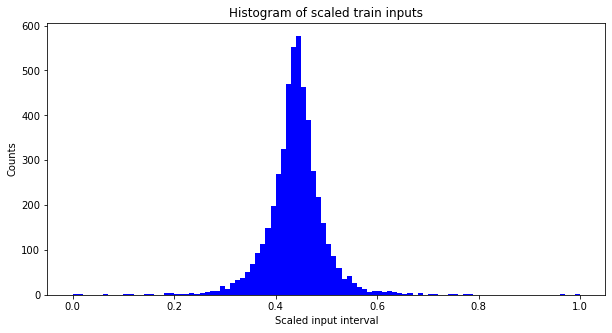

In [156]:
# Plot histogram of scaled inputs: Feature 1 (sp500 close (rel chg))
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_input_scaled[:,0,0], nBins, color="blue")
axes.set_xlabel("Scaled input interval")
axes.set_ylabel("Counts")
axes.set_title("Histogram of scaled train inputs")
plt.show()

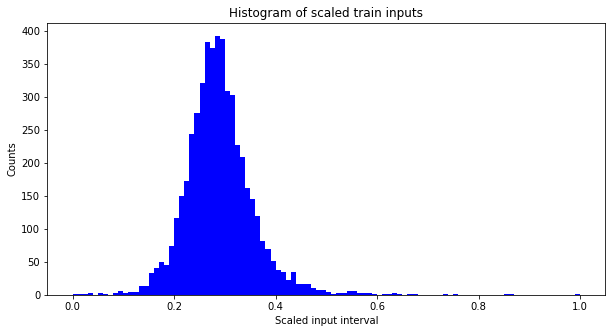

In [157]:
## ONLY if we have second input feature!

# Plot histogram of scaled inputs: Feature 2 (vix close (rel chg))
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_input_scaled[:,0,1], nBins, color="blue")
axes.set_xlabel("Scaled input interval")
axes.set_ylabel("Counts")
axes.set_title("Histogram of scaled train inputs")
plt.show()

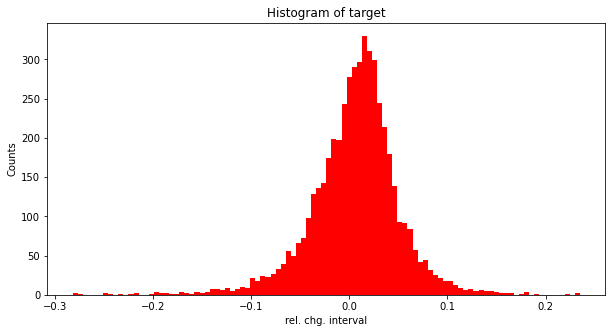

In [158]:
# Plot histogram of targets
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_target[:,0], nBins, color="red")
axes.set_xlabel("rel. chg. interval")
axes.set_ylabel("Counts")
axes.set_title("Histogram of target")
plt.show()

In [167]:
# Set up compiled CNN/fc model:
model = set_CNN_fc(CNN_filters, CNN_kernel_sizes, fc_units, fc_hidden_activation,
                   n_epochs, batch_size, learning_rate, loss_function)
model.summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_108 (Conv1D)          (None, 16, 10)            110       
_________________________________________________________________
batch_normalization_108 (Bat (None, 16, 10)            40        
_________________________________________________________________
leaky_re_lu_108 (LeakyReLU)  (None, 16, 10)            0         
_________________________________________________________________
conv1d_109 (Conv1D)          (None, 12, 20)            1020      
_________________________________________________________________
batch_normalization_109 (Bat (None, 12, 20)            80        
_________________________________________________________________
leaky_re_lu_109 (LeakyReLU)  (None, 12, 20)            0         
_________________________________________________________________
flatten_54 (Flatten)         (None, 240)             

In [168]:
# Train model on scaled inputs and un-scaled targets:
history = model.fit(train_input_scaled, train_target, epochs=n_epochs, batch_size=batch_size,
                    shuffle=True, verbose=2, validation_data=(val_input_scaled, val_target))

Epoch 1/10
252/252 - 1s - loss: 0.1019 - val_loss: 0.0267
Epoch 2/10
252/252 - 0s - loss: 0.0055 - val_loss: 0.0022
Epoch 3/10
252/252 - 0s - loss: 0.0028 - val_loss: 0.0019
Epoch 4/10
252/252 - 0s - loss: 0.0026 - val_loss: 0.0017
Epoch 5/10
252/252 - 0s - loss: 0.0024 - val_loss: 0.0016
Epoch 6/10
252/252 - 0s - loss: 0.0024 - val_loss: 0.0015
Epoch 7/10
252/252 - 0s - loss: 0.0023 - val_loss: 0.0015
Epoch 8/10
252/252 - 0s - loss: 0.0023 - val_loss: 0.0015
Epoch 9/10
252/252 - 0s - loss: 0.0022 - val_loss: 0.0014
Epoch 10/10
252/252 - 0s - loss: 0.0022 - val_loss: 0.0014


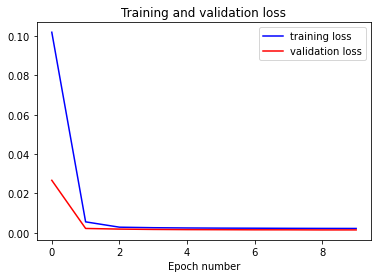

In [169]:
# Plot train and val_loss (mse)
plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation loss')
plt.legend()
plt.show() 

In [170]:
# Get model predictions:
train_pred = model.predict(train_input_scaled)
val_pred = model.predict(val_input_scaled)
test_pred = model.predict(test_input_scaled)

# Convert to binary prediction UP (1) / DOWN (0):
train_pred_bin = (train_pred>0).astype(int)
val_pred_bin = (val_pred>0).astype(int)
test_pred_bin = (test_pred>0).astype(int)

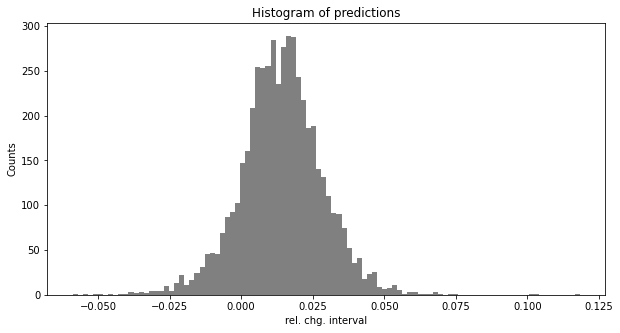

In [171]:
# Plot histogram of predictions
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_pred[:,0], nBins, color="grey")
axes.set_xlabel("rel. chg. interval")
axes.set_ylabel("Counts")
axes.set_title("Histogram of predictions")
plt.show()

In [172]:
# Get binary prediction accuracy - in terms of correctly predicted up/down movements:
train_acc = np.sum(train_pred_bin == train_target_bin) / len(train_pred_bin)
val_acc = np.sum(val_pred_bin == val_target_bin) / len(val_pred_bin)
test_acc = np.sum(test_pred_bin == test_target_bin) / len(test_pred_bin)

# Get "naive" accuracy, when we always predict an UP movement.
# In other words this reflects the relative amount of UP movements.
train_acc_naiv = np.sum(train_target_bin / len(train_target))
val_acc_naiv = np.sum(val_target_bin / len(val_target))
test_acc_naiv = np.sum(test_target_bin / len(test_target))

print("train acc (%): ", np.round(train_acc * 100,1), "%")
print("val acc (%): ", np.round(val_acc * 100,1), "%")
print("test acc (%)", np.round(test_acc * 100,1), "%")
print("\nnaive train acc (%)", np.round(train_acc_naiv * 100,1), "%")
print("naive val acc (%)", np.round(val_acc_naiv * 100,1), "%")
print("naive test acc (%)", np.round(test_acc_naiv * 100,1), "%")

train acc (%):  58.5 %
val acc (%):  61.9 %
test acc (%) 60.6 %

naive train acc (%) 60.8 %
naive val acc (%) 67.2 %
naive test acc (%) 66.1 %


### Discussion: Single-run CNN/fc model

The model trains well, find predictions somewhat centered arround *zero*, as the histogram of targets shows. But the accuracy is poor - compared to naive accuracy. Our model is not better than just **random guessing**, if trained only on **SP500 and VIX close_rel_chg** as *combined* input features in *single-run* mode.

### CNN/fc model: Multi-run experiment on SP500 and VIX close (rel. chg.) as combined input features

Try to train **n_runs = 11** models (to have an uneven number!) on SP500 and VIX close (rel. chg.) as *two* combined input features and use SP500 close (rel. chg.) as target. Assume **optimal input length** to be **20d**. Do the experiment **for all target length** 1d/5d/10d/20d seperately. Use regular **mse loss**.

** Questions to be answered before we proceed with FULL model in TWO-STEP process:**
- What accuracy do we reach, if we use UP / DOWN as majority vote from all 11 model predictions (UP: At least 6 models predict an UP movement, DOWN: else)?
- Better or worse than random guessing?

**Fix base parameters as follows:**

- weight_init = tfi.glorot_uniform()
- bias_init = tfi.Zeros()
- CNN_filters = [10,20]
- CNN_kernel_sizes = [5,5]
- fc_units = [20,10]
- fc_hidden_activation = 'sigmoid'
- n_epochs = 20
- batch_size = 10
- learning_rate = 0.0001
- loss_function = 'mse'

**SAVED RESULTS:** Where binary predictions on train, validation and test data meet binary targets PLUS all predictions from all runs.

- histories_multirun_07a.npy --> train_correct_pred
- histories_multirun_07b.npy --> val_correct_pred
- histories_multirun_07c.npy --> test_correct_pred
- histories_multirun_07d.npy --> train_pred_all
- histories_multirun_07e.npy --> val_pred_all
- histories_multirun_07f.npy --> test_pred_all

In [8]:
## Set parameters:

# Number of runs for each setting:
n_runs = 11

# Fixed model parameters:
weight_init = tfi.glorot_uniform() # Taken as default.
bias_init = tfi.Zeros() # Taken as default.
CNN_filters = [10,20]
CNN_kernel_sizes = [5,5]
fc_units = [20,10]
fc_hidden_activation = 'sigmoid'
n_epochs = 10
batch_size = 20
learning_rate = 0.0001
loss_function = 'mse' # String ('mse', 'custom_mse' or 'custom_loss') to choose the loss function.

In [9]:
# Parameters to be chosen for pre-processing:
input_features = (0,1) # 0: close (rel. chg.), 1: volume (rel. chg.), 2: range (rel.)
target_horizons = [(0,), (1,), (2,), (3,),] # 0: 1d, 1: 5d, 2: 10d, 3: 20d
input_length = 20

# For plotting: Declare target_horizons as real text:
target_horizons_text = ["1d", "5d", "10d", "20d"]

In [10]:
## Pre-process inputs and targets for first target horizon already.
## That's necessary to have the correct dimensions for storing model predictions later on.

# Select specified input features:
inputs_selected = inputs[:,input_features]

# Select target horizon:
target_selected = targets[:, target_horizons[0]]

# Split input values into sequences of specified input length:
inputs_split = split_sequence(inputs_selected, input_length)

# Adjust data, year and targets: Cut first (input_length - 1) entries
data_cut = data[input_length-1:]
year_cut = year[input_length-1:]
target_cut = target_selected[input_length-1:]

## Split inputs and targets into train / validation / test sets, according to year:

# Train data: 1990 .. 2009
# Val data:   2010 .. 2019
# Test data:  2020 .. end

train_input = inputs_split[year_cut <= 2009]
val_input = inputs_split[(year_cut >= 2010) & (year_cut < 2020)]
test_input = inputs_split[year_cut >= 2020]

train_target = target_cut[year_cut <= 2009]
val_target = target_cut[(year_cut >= 2010) & (year_cut < 2020)]
test_target = target_cut[year_cut >= 2020]

# Convert to binary targets (up = 1, down = 0):
train_target_bin = train_target>0
val_target_bin = val_target>0
test_target_bin = test_target>0

In [36]:
# Initialize storage for predictions and correct predictions for ALL target horizons.
# Desired shape: (#target horizons, #runs, #samples)
train_pred_all = np.zeros((len(target_horizons), n_runs, len(train_target)))
val_pred_all = np.zeros((len(target_horizons), n_runs, len(val_target)))
test_pred_all = np.zeros((len(target_horizons), n_runs, len(test_target)))
train_correct_pred = np.zeros((len(target_horizons), n_runs, len(train_target)))
val_correct_pred = np.zeros((len(target_horizons), n_runs, len(val_target)))
test_correct_pred = np.zeros((len(target_horizons), n_runs, len(test_target)))

In [37]:
# Loop over target horizons:
for i in range(len(target_horizons)):
    
    # Get current target horizon:
    target_horizon = target_horizons[i]
    
    # Print status:
    print("Target horizon: ", i+1, " of ", len(target_horizons))
            
    ## Pre-process inputs and targets: (Note: For first tareget_horizon this step is redundant.)

    # Select specified input features:
    inputs_selected = inputs[:,input_features]

    # Select target horizon:
    target_selected = targets[:, target_horizon]

    # Split input values into sequences of specified input length:
    inputs_split = split_sequence(inputs_selected, input_length)

    # Adjust data, year and targets: Cut first (input_length - 1) entries
    data_cut = data[input_length-1:]
    year_cut = year[input_length-1:]
    target_cut = target_selected[input_length-1:]

    ## Split inputs and targets into train / validation / test sets, according to year:

    # Train data: 1990 .. 2009
    # Val data:   2010 .. 2019
    # Test data:  2020 .. end

    train_input = inputs_split[year_cut <= 2009]
    val_input = inputs_split[(year_cut >= 2010) & (year_cut < 2020)]
    test_input = inputs_split[year_cut >= 2020]

    train_target = target_cut[year_cut <= 2009]
    val_target = target_cut[(year_cut >= 2010) & (year_cut < 2020)]
    test_target = target_cut[year_cut >= 2020]

    # Convert to binary targets (up = 1, down = 0):
    train_target_bin = train_target>0
    val_target_bin = val_target>0
    test_target_bin = test_target>0

    # Get min and max for ALL input features from TRAIN data:
    train_min = np.min(train_input, axis=(0,1))
    train_max = np.max(train_input, axis=(0,1))

    # Apply min max scaling to train / val / test inputs: Substract min and divide by (max - min)
    train_input_scaled = (train_input - train_min) / (train_max - train_min)
    val_input_scaled = (val_input - train_min) / (train_max - train_min)
    test_input_scaled = (test_input - train_min) / (train_max - train_min)
    
    # Loop over number of runs:
    for n_run in range(n_runs):

        # Print status:
        print("  Run: ", n_run+1, " of ", n_runs)

        # Set up compiled model:
        model = set_CNN_fc(
            CNN_filters, CNN_kernel_sizes, fc_units, fc_hidden_activation,
            n_epochs, batch_size, learning_rate, loss_function
        )

        # Train model on scaled inputs and un-scaled targets:
        history = model.fit(
            train_input_scaled, train_target,
            epochs=n_epochs, batch_size=batch_size, 
            shuffle=True, verbose=0, 
            validation_data=(val_input_scaled, val_target)
        )

        # Get model predictions:
        train_pred = model.predict(train_input_scaled)
        val_pred = model.predict(val_input_scaled)
        test_pred = model.predict(test_input_scaled)
        
        # Convert to binary predictions (up = 1, down = 0):
        train_pred_bin = (train_pred > 0)
        val_pred_bin = (val_pred > 0)
        test_pred_bin = (test_pred > 0)
        
        # Store model predictions on train, validation and test data
        train_pred_all[i,n_run,:] = train_pred[:,0]
        val_pred_all[i,n_run,:] = val_pred[:,0]
        test_pred_all[i,n_run,:] = test_pred[:,0]  
        
        # Store for current run where binary predictions on train, validation and test data meet binary targets:
        train_correct_pred[i,n_run,:] = ((train_pred_bin == train_target_bin).astype(int)[:,0])
        val_correct_pred[i,n_run,:] = (val_pred_bin == val_target_bin).astype(int)[:,0]
        test_correct_pred[i,n_run,:] = (test_pred_bin == test_target_bin).astype(int)[:,0]

Target horizon:  1  of  4
  Run:  1  of  11
  Run:  2  of  11
  Run:  3  of  11
  Run:  4  of  11
  Run:  5  of  11
  Run:  6  of  11
  Run:  7  of  11
  Run:  8  of  11
  Run:  9  of  11
  Run:  10  of  11
  Run:  11  of  11
Target horizon:  2  of  4
  Run:  1  of  11
  Run:  2  of  11
  Run:  3  of  11
  Run:  4  of  11
  Run:  5  of  11
  Run:  6  of  11
  Run:  7  of  11
  Run:  8  of  11
  Run:  9  of  11
  Run:  10  of  11
  Run:  11  of  11
Target horizon:  3  of  4
  Run:  1  of  11
  Run:  2  of  11
  Run:  3  of  11
  Run:  4  of  11
  Run:  5  of  11
  Run:  6  of  11
  Run:  7  of  11
  Run:  8  of  11
  Run:  9  of  11
  Run:  10  of  11
  Run:  11  of  11
Target horizon:  4  of  4
  Run:  1  of  11
  Run:  2  of  11
  Run:  3  of  11
  Run:  4  of  11
  Run:  5  of  11
  Run:  6  of  11
  Run:  7  of  11
  Run:  8  of  11
  Run:  9  of  11
  Run:  10  of  11
  Run:  11  of  11


In [11]:
### Save and reload histories:

# np.save('../results/histories_multirun_07a.npy', train_correct_pred)
# np.save('../results/histories_multirun_07b.npy', val_correct_pred)
# np.save('../results/histories_multirun_07c.npy', test_correct_pred)
# np.save('../results/histories_multirun_07d.npy', train_pred_all)
# np.save('../results/histories_multirun_07e.npy', val_pred_all)
# np.save('../results/histories_multirun_07f.npy', test_pred_all)

# train_correct_pred = np.load('../results/histories_multirun_07a.npy')
# val_correct_pred = np.load('../results/histories_multirun_07b.npy')
# test_correct_pred = np.load('../results/histories_multirun_07c.npy')
# train_pred_all = np.load('../results/histories_multirun_07d.npy')
# val_pred_all = np.load('../results/histories_multirun_07e.npy')
# test_pred_all = np.load('../results/histories_multirun_07f.npy')


## Additional parameters to restore plots subsequent steps from re-loaded data:
# target_horizons = [(0,), (1,), (2,), (3,),] # 0: 1d, 1: 5d, 2: 10d, 3: 20d
# input_length = 20
# target_horizons_text = ["1d", "5d", "10d", "20d"]
# n_epochs = 10

In [19]:
train_correct_pred.shape

(4, 11, 5023)

In [12]:
## Post-Processing: Count correct predictions over number of runs.
sum_train_correct_pred = np.sum(train_correct_pred, axis=1)
sum_val_correct_pred = np.sum(val_correct_pred, axis=1)
sum_test_correct_pred = np.sum(test_correct_pred, axis=1)

# Count number of models that predicted an UP movement (>0).
# Get majority vote: More or equal to 6 models predicting UP movement, we take UP as ensemble prediction.
# Create binary target UP = 1, DOWN = 0:
ensemble_train_pred_bin = (np.sum((train_pred_all > 0), axis=1) >= 6).astype(int)
ensemble_val_pred_bin = (np.sum((val_pred_all > 0), axis=1) >= 6).astype(int)
ensemble_test_pred_bin = (np.sum((test_pred_all > 0), axis=1) >= 6).astype(int)

In [13]:
# Get binary targets for ALL target horizons:
target_selected = targets[:,]

# Adjust year and targets: Cut first (input_length - 1) entries
year_cut = year[input_length-1:]
target_cut = target_selected[input_length-1:]

## Split inputs and targets into train / validation / test sets, according to year:

# Train data: 1990 .. 2009
# Val data:   2010 .. 2019
# Test data:  2020 .. end

train_target = target_cut[year_cut <= 2009]
val_target = target_cut[(year_cut >= 2010) & (year_cut < 2020)]
test_target = target_cut[year_cut >= 2020]

# Convert to binary targets (up = 1, down = 0):
train_target_bin = train_target>0
val_target_bin = val_target>0
test_target_bin = test_target>0

In [14]:
## Get accuracies when using ensemble prediction:

# Train data:
print("Train acc | naive acc")
# Loop over target horizons:
for t in range(len(target_horizons_text)):

    # Get accuracies, but note: ensemble prediction has target horizon as first dimension, 
    # whereas targets have target horizon as last dimension.
    print(target_horizons_text[t]+": "+
          str(np.round(sum(ensemble_train_pred_bin[t,:]==train_target_bin[:,t])/len(train_target_bin[:,t]),3))+"  "+
          str(np.round(sum(train_target_bin[:,t])/len(train_target_bin[:,t]),3)))

# Val data:
print("\nVal acc   | naive acc")
# Loop over target horizons:
for t in range(len(target_horizons_text)):

    # Get accuracies, but note: ensemble prediction has target horizon as first dimension, 
    # whereas targets have target horizon as last dimension.
    print(target_horizons_text[t]+": "+
          str(np.round(sum(ensemble_val_pred_bin[t,:]==val_target_bin[:,t])/len(val_target_bin[:,t]),3))+"  "+
          str(np.round(sum(val_target_bin[:,t])/len(val_target_bin[:,t]),3)))
    
# Test data:
print("\nTest acc  | naive acc")
# Loop over target horizons:
for t in range(len(target_horizons_text)):

    # Get accuracies, but note: ensemble prediction has target horizon as first dimension, 
    # whereas targets have target horizon as last dimension.
    print(target_horizons_text[t]+": "+
          str(np.round(sum(ensemble_test_pred_bin[t,:]==test_target_bin[:,t])/len(test_target_bin[:,t]),3))+"  "+
          str(np.round(sum(test_target_bin[:,t])/len(test_target_bin[:,t]),3)))

Train acc | naive acc
1d: 0.516  0.53
5d: 0.555  0.558
10d: 0.578  0.578
20d: 0.594  0.608

Val acc   | naive acc
1d: 0.49  0.548
5d: 0.529  0.607
10d: 0.556  0.639
20d: 0.585  0.672

Test acc  | naive acc
1d: 0.518  0.542
5d: 0.497  0.602
10d: 0.541  0.636
20d: 0.533  0.661


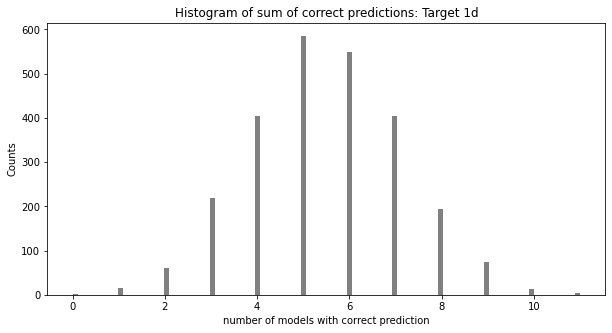

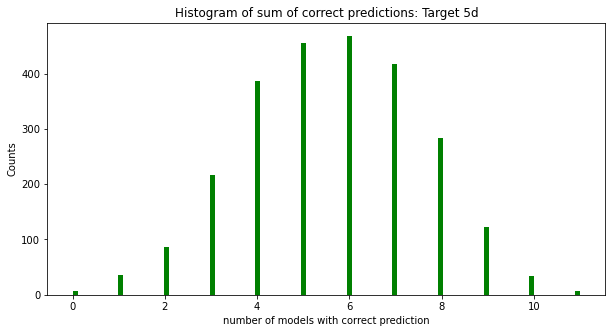

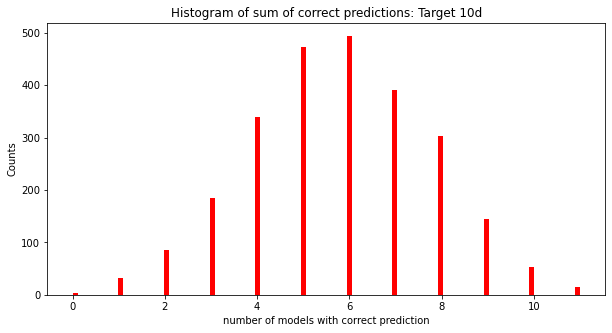

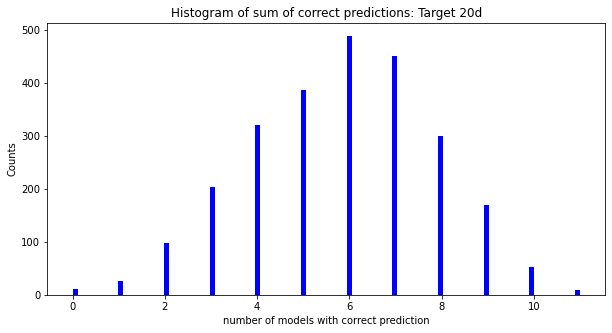

In [15]:
# Plot histogram of sum of correct predictions from multi-run experiment with n_runs
# seperately for different target horizons:

target_horizons_text = ["1d", "5d", "10d", "20d"]
colors = ["grey", "green", "red", "blue"]

# Loop over target horizons:
for t in range(len(target_horizons_text)):
    nBins = 100
    fig, axes = plt.subplots(1, 1, figsize=(10,5))
    axes.hist(sum_val_correct_pred[t,:], nBins, color=colors[t])
    axes.set_xlabel("number of models with correct prediction")
    axes.set_ylabel("Counts")
    axes.set_title("Histogram of sum of correct predictions: Target " + target_horizons_text[t])
    plt.show()

### Discussion on multi-run experiment on SP500 and VIX close (rel. chg.) as combined input features

As expected, we stay behind naive accuracy, when we train an ensemble of models on SP500 and VIX close (rel. chg.) as *combined* input features - for all target horizons.


For all target horizons 1d / 5d / 10d / 20d we find some Gaussian distribution of number of models with correct prediction, somewhat centered arround 5 of 6, so quite in the middle, when we have *n_runs = 11*. That is not a good basis for finding a **partition of high / low reliability** samples on the time line.

Together, this motivates to proceed with the **TWO-STEP** process and set up a FULL model.

### Train a FULL model in a TWO STEP process

#### Part 1:
- Train and store 11 models on SP500 close (rel. chg.) input samples of length 20d on SP500 close (rel. chg.) target with horizon 20d. Then:
 - Get an ensemble predictor to create a continuous target with discrete values: "number of correct predictions".
 - Also create a binary ensemble predictor HIGH / LOW reliability from number of correct predictions (HIGH: At least 6 models' prediction was pointing in the right direction, LOW: else). --> This is only used for visualization of partitioning to show that there are indead *regimes* where model predictions work better or worse. On average, the prediction accuracy is poor, compared to random guessing.
 - And derive a binary ensemble predictor UP / DOWN as majority vote from all 11 model predictions (UP: At least 6 models predict an UP movement, DOWN: else). --> This is only used for visualization of HOW we would act, if final model classifies VIX sample as HIGH reliable.

#### Part 2:
- Train and store another 11 models on VIX close (rel. chg.) input samples of length 20d on continuous target "number of correct predictions".
- Derive a binary prediction to classify VIX samples a HIGH / LOW reliable, according to predicted number of correct predictions (HIGH: Prediction is greater or equal to 6, LOW: else). --> This actually tells us, WHERE we act, according to binary ensemble predictor UP or DOWN.

#### Performance check:
- Check accumulated profits for different strategies:
 - Act only on HIGH-reliability spots and then ALWAYS go LONG.
 - Act only on HIGH-reliability spots but according to ensemble predictor: UP or DOWN.
 - Naive buy and hold-strategy: Act always and always LONG.
 
**SAVED RESULTS:** Where binary predictions on train, validation and test data meet binary targets PLUS all predictions from all runs.

**Part 1:**

- histories_multirun_08a.npy --> train_correct_pred
- histories_multirun_08b.npy --> val_correct_pred
- histories_multirun_08c.npy --> test_correct_pred
- histories_multirun_08d.npy --> train_pred_all
- histories_multirun_08e.npy --> val_pred_all
- histories_multirun_08f.npy --> test_pred_all

*../models/part1/model_1 .. model_11*

**Part 2:**

- histories_multirun_09a.npy --> train_correct_pred
- histories_multirun_09b.npy --> val_correct_pred
- histories_multirun_09c.npy --> test_correct_pred
- histories_multirun_09d.npy --> train_pred_all
- histories_multirun_09e.npy --> val_pred_all
- histories_multirun_09f.npy --> test_pred_all

*../models/part2/model_1 .. model_11*

#### Pre-process inputs and targets

In [16]:
## Start over new:

# Extract year for seperating data into train / validation / test sets
year = data[:,0]

## Extract sp500 and vix close (rel chg) as input features.
# [2] - sp500 close (rel chg) 
# [4] - vix close (rel chg)

inputs = data[:,(2,4)]

## Extract target values for 1d / 5d / 10d / 20d as rel chg:
# [5] - target 1d (rel chg)
# [6] - target 5d (rel chg)
# [7] - target 10d (rel chg)
# [8] - target 20d (rel chg)

targets = data[:,5:]

# Check dimensions:
print("year shape (samples): ", year.shape)
print("inputs shape (samples, input features): ", inputs.shape)
print("targets shape (samples, output features): ", targets.shape)

year shape (samples):  (8218,)
inputs shape (samples, input features):  (8218, 2)
targets shape (samples, output features):  (8218, 4)


In [17]:
## Set parameters:

# Number of runs:
n_runs = 11

# Data pre-processing:
input_features = (0,) # 0: sp500 close (rel. chg.), 1: vix close (rel. chg.)
target_horizon = (3,) # 0: 1d, 1: 5d, 2: 10d, 3: 20d
input_length = 20

# Model parameters:
weight_init = tfi.glorot_uniform() # Taken as default.
bias_init = tfi.Zeros() # Taken as default.
CNN_filters = [10,20]
CNN_kernel_sizes = [5,5]
fc_units = [20,10]
fc_hidden_activation = 'sigmoid'
n_epochs = 10
batch_size = 20
learning_rate = 0.0001
loss_function = 'mse' # ('mse', custom_mse or custom_loss) to choose the loss function.

In [18]:
## Pre-process inputs and targets:

# Select specified input features:
inputs_selected = inputs[:,input_features]

# Select target horizon:
target_selected = targets[:, target_horizon]

# Split input values into sequences of specified input length:
inputs_split = split_sequence(inputs_selected, input_length)

# Adjust data, year and targets: Cut first (input_length - 1) entries
data_cut = data[input_length-1:]
year_cut = year[input_length-1:]
target_cut = target_selected[input_length-1:]

## Split inputs and targets into train / validation / test sets, according to year:

# Train data: 1990 .. 2009
# Val data:   2010 .. 2019
# Test data:  2020 .. end

train_input = inputs_split[year_cut <= 2009]
val_input = inputs_split[(year_cut >= 2010) & (year_cut < 2020)]
test_input = inputs_split[year_cut >= 2020]

train_target = target_cut[year_cut <= 2009]
val_target = target_cut[(year_cut >= 2010) & (year_cut < 2020)]
test_target = target_cut[year_cut >= 2020]

# Convert to binary targets (up = 1, down = 0):
train_target_bin = (train_target>0).astype(int)
val_target_bin = (val_target>0).astype(int)
test_target_bin = (test_target>0).astype(int)

# Check dimensions:
print("train_input shape (samples, time steps, features): ", train_input.shape)
print("val_input shape (samples, time steps, features): ", val_input.shape)
print("test_input shape (samples, time steps, features): ", test_input.shape)
print("\ntrain_target shape (samples, features): ", train_target.shape)
print("val_target shape (samples, features): ", val_target.shape)
print("test_target shape (samples, features): ", test_target.shape)
print("\ntrain_target_bin shape (samples, features): ", train_target_bin.shape)
print("val_target shape_bin (samples, features): ", val_target_bin.shape)
print("test_target shape_bin (samples, features): ", test_target_bin.shape)

# Get min and max for ALL input features from TRAIN data:
train_min = np.min(train_input, axis=(0,1))
train_max = np.max(train_input, axis=(0,1))

# Apply min max scaling to train / val / test inputs: Substract min and divide by (max - min)
train_input_scaled = (train_input - train_min) / (train_max - train_min)
val_input_scaled = (val_input - train_min) / (train_max - train_min)
test_input_scaled = (test_input - train_min) / (train_max - train_min)

# Check result:
print("\ntrain_input MIN: ", np.round(np.min(train_input_scaled, axis=(0,1)), 2))
print("train_input MAX: ", np.round(np.max(train_input_scaled, axis=(0,1)), 2))
print("\nval_input MIN: ", np.round(np.min(val_input_scaled, axis=(0,1)), 2))
print("val_input MAX: ", np.round(np.max(val_input_scaled, axis=(0,1)), 2))
print("\ntest_input MIN: ", np.round(np.min(test_input_scaled, axis=(0,1)), 2))
print("test_input MAX: ", np.round(np.max(test_input_scaled, axis=(0,1)), 2))

train_input shape (samples, time steps, features):  (5023, 20, 1)
val_input shape (samples, time steps, features):  (2516, 20, 1)
test_input shape (samples, time steps, features):  (660, 20, 1)

train_target shape (samples, features):  (5023, 1)
val_target shape (samples, features):  (2516, 1)
test_target shape (samples, features):  (660, 1)

train_target_bin shape (samples, features):  (5023, 1)
val_target shape_bin (samples, features):  (2516, 1)
test_target shape_bin (samples, features):  (660, 1)

train_input MIN:  [0.]
train_input MAX:  [1.]

val_input MIN:  [0.12]
val_input MAX:  [0.68]

test_input MIN:  [-0.14]
test_input MAX:  [0.89]


#### Part 1 of TWO-STEP process

- Train and store 11 models on SP500 close (rel. chg.) input samples of length 20d on SP500 close (rel. chg.) target with horizon 20d. Then:
 - Get an ensemble predictor to create a continuous target with discrete values: "number of correct predictions".
 - Also create a binary ensemble predictor HIGH / LOW reliability from number of correct predictions (HIGH: At least 6 models' prediction was pointing in the right direction, LOW: else). --> This is only used for visualization of partitioning to show that there are indead *regimes* where model predictions work better or worse. On average, the prediction accuracy is poor, compared to random guessing.
 - And derive a binary ensemble predictor UP / DOWN as majority vote from all 11 model predictions (UP: At least 6 models predict an UP movement, DOWN: else). --> This is only used for visualization of HOW we would act, if final model classifies VIX sample as HIGH reliable.

In [18]:
# Initialize storage for predictions and correct predictions for target = 20d
# Desired shape: (#runs, #samples)

train_pred_all = np.zeros((n_runs, len(train_target)))
val_pred_all = np.zeros((n_runs, len(val_target)))
test_pred_all = np.zeros((n_runs, len(test_target)))
train_correct_pred = np.zeros((n_runs, len(train_target)))
val_correct_pred = np.zeros((n_runs, len(val_target)))
test_correct_pred = np.zeros((n_runs, len(test_target)))

# Initialize storage for models of first part:
models_part1 = []

# Loop over number of runs:
for n_run in range(n_runs):

    # Print status:
    print("Run: ", n_run+1, " of ", n_runs)

    # Set up compiled model:
    model = set_CNN_fc(
        CNN_filters, CNN_kernel_sizes, fc_units, fc_hidden_activation,
        n_epochs, batch_size, learning_rate, loss_function
    )

    # Train model on scaled inputs and un-scaled targets:
    history = model.fit(
        train_input_scaled, train_target,
        epochs=n_epochs, batch_size=batch_size, 
        shuffle=True, verbose=0
    )
    
    # Store trained model:
    models_part1.append(model)

    # Get model predictions:
    train_pred = model.predict(train_input_scaled)
    val_pred = model.predict(val_input_scaled)
    test_pred = model.predict(test_input_scaled)

    # Convert to binary predictions (up = 1, down = 0):
    train_pred_bin = (train_pred > 0)
    val_pred_bin = (val_pred > 0)
    test_pred_bin = (test_pred > 0)

    # Store model predictions on train, validation and test data
    train_pred_all[n_run,:] = train_pred[:,0]
    val_pred_all[n_run,:] = val_pred[:,0]
    test_pred_all[n_run,:] = test_pred[:,0]  

    # Store for current run where binary predictions on train, validation and test data meet binary targets:
    train_correct_pred[n_run,:] = ((train_pred_bin == train_target_bin).astype(int)[:,0])
    val_correct_pred[n_run,:] = (val_pred_bin == val_target_bin).astype(int)[:,0]
    test_correct_pred[n_run,:] = (test_pred_bin == test_target_bin).astype(int)[:,0]

Run:  1  of  11


2022-09-17 18:07:55.043472: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-17 18:07:55.138725: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Run:  2  of  11


KeyboardInterrupt: 

In [196]:
### Save and reload trained models for part 1:

## Save models:

# # Loop over models from part 1:
# for model_number in range(n_runs):
#     path_to_model = '../models/part1/model_'+str(model_number+1)
#     models_part1[model_number].save(path_to_model)

## Reload trained models:

# # Initialize storage for models of part 1:
# models_part1 = []

# # Loop over models from part 1:
# for model_number in range(n_runs):
#     path_to_model = '../models/part1/model_'+str(model_number+1)
#     model = tf.keras.models.load_model(path_to_model)
#     models_part1.append(model)

In [19]:
### Save and reload histories:

# np.save('../results/histories_multirun_08a.npy', train_correct_pred)
# np.save('../results/histories_multirun_08b.npy', val_correct_pred)
# np.save('../results/histories_multirun_08c.npy', test_correct_pred)
# np.save('../results/histories_multirun_08d.npy', train_pred_all)
# np.save('../results/histories_multirun_08e.npy', val_pred_all)
# np.save('../results/histories_multirun_08f.npy', test_pred_all)

# train_correct_pred = np.load('../results/histories_multirun_08a.npy')
# val_correct_pred = np.load('../results/histories_multirun_08b.npy')
# test_correct_pred = np.load('../results/histories_multirun_08c.npy')
# train_pred_all = np.load('../results/histories_multirun_08d.npy')
# val_pred_all = np.load('../results/histories_multirun_08e.npy')
# test_pred_all = np.load('../results/histories_multirun_08f.npy')

## Or re-load former results for target 20d, but didn't save models!

# train_correct_pred = np.load('../results/histories_multirun_05a.npy')[3]
# val_correct_pred = np.load('../results/histories_multirun_05b.npy')[3]
# test_correct_pred = np.load('../results/histories_multirun_05c.npy')[3]
# train_pred_all = np.load('../results/histories_multirun_05d.npy')[3]
# val_pred_all = np.load('../results/histories_multirun_05e.npy')[3]
# test_pred_all = np.load('../results/histories_multirun_05f.npy')[3]


## Additional parameters to restore plots subsequent steps from re-loaded data:
# target_horizons = [(3,),] # 0: 1d, 1: 5d, 2: 10d, 3: 20d
# input_length = 20
# n_epochs = 10

In [20]:
## Post-Processing: Count correct predictions over number of runs.
sum_train_correct_pred = np.sum(train_correct_pred, axis=0)
sum_val_correct_pred = np.sum(val_correct_pred, axis=0)
sum_test_correct_pred = np.sum(test_correct_pred, axis=0)

## Get absolute closing price for SP500 and VIX from cut data by splitting according to year:

# Train data: 1990 .. 2009
# Val data:   2010 .. 2019
# Test data:  2020 .. end

# SP500
train_close_abs = data_cut[year_cut <= 2009][:,1]
val_close_abs = data_cut[(year_cut >= 2010) & (year_cut < 2020)][:,1]
test_close_abs = data_cut[year_cut >= 2020][:,1]

# VIX
vix_train_close_abs = data_cut[year_cut <= 2009][:,3]
vix_val_close_abs = data_cut[(year_cut >= 2010) & (year_cut < 2020)][:,3]
vix_test_close_abs = data_cut[year_cut >= 2020][:,3]

# # Check dimensions:
print("sum_train_correct_pred shape: (#target horizons, samples)", sum_train_correct_pred.shape)
print("sum_val_correct_pred shape: (#target horizons, samples)", sum_val_correct_pred.shape)
print("sum_test_correct_pred shape: (#target horizons, samples)", sum_test_correct_pred.shape)
print("\ntrain_close_abs shape (samples): ", train_close_abs.shape)
print("val_close_abs shape (samples): ", val_close_abs.shape)
print("test_close_abs shape (samples): ", test_close_abs.shape)
print("\nvix_train_close_abs shape (samples): ", train_close_abs.shape)
print("vix_val_close_abs shape (samples): ", val_close_abs.shape)
print("vix_test_close_abs shape (samples): ", test_close_abs.shape)

sum_train_correct_pred shape: (#target horizons, samples) (5023,)
sum_val_correct_pred shape: (#target horizons, samples) (2516,)
sum_test_correct_pred shape: (#target horizons, samples) (660,)

train_close_abs shape (samples):  (5023,)
val_close_abs shape (samples):  (2516,)
test_close_abs shape (samples):  (660,)

vix_train_close_abs shape (samples):  (5023,)
vix_val_close_abs shape (samples):  (2516,)
vix_test_close_abs shape (samples):  (660,)


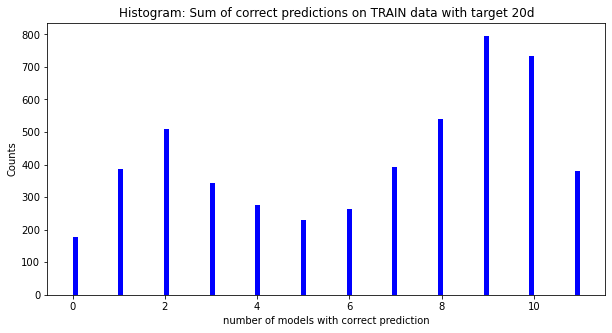

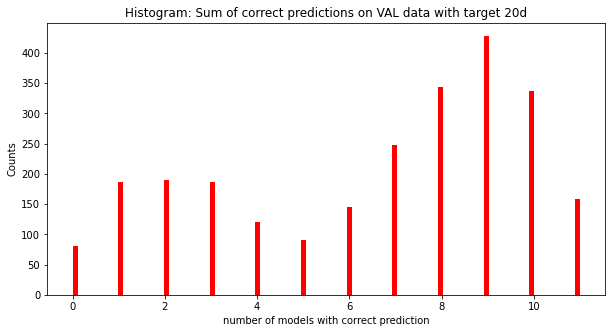

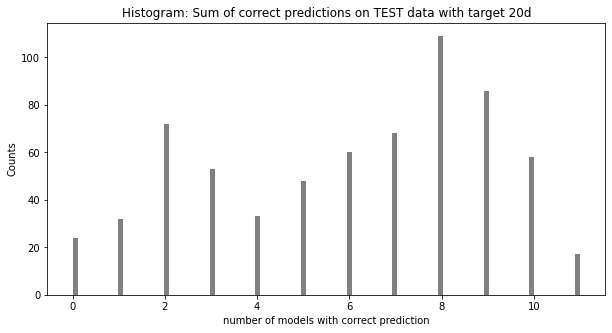

In [21]:
## Plot histogram of sum of correct predictions from multi-run experiment with n_runs for target horizon 20d:

# Train
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(sum_train_correct_pred, nBins, color='blue')
axes.set_xlabel("number of models with correct prediction")
axes.set_ylabel("Counts")
axes.set_title("Histogram: Sum of correct predictions on TRAIN data with target 20d")
plt.show()

# Val
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(sum_val_correct_pred, nBins, color='red')
axes.set_xlabel("number of models with correct prediction")
axes.set_ylabel("Counts")
axes.set_title("Histogram: Sum of correct predictions on VAL data with target 20d")
plt.show()

#Test
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(sum_test_correct_pred, nBins, color='grey')
axes.set_xlabel("number of models with correct prediction")
axes.set_ylabel("Counts")
axes.set_title("Histogram: Sum of correct predictions on TEST data with target 20d")
plt.show()

In [22]:
## Get an ensemble predictor to create a continuous target with discrete values: "number of correct predictions".
# Take sum of correct predictions from multirun experiment (part 1). Reshape to have dimensions (samples, 1).
train_target_true_pred = sum_train_correct_pred.reshape((len(sum_train_correct_pred), 1))
val_target_true_pred = sum_val_correct_pred.reshape((len(sum_val_correct_pred), 1))
test_target_true_pred = sum_test_correct_pred.reshape((len(sum_test_correct_pred), 1))

In [23]:
## Also create a binary ensemble predictor HIGH / LOW reliability from number of correct predictions. 
# HIGH: At least 6 models' prediction was pointing in the right direction, LOW: else.
# Note: This is only used for visualization of partitioning to show that there are indead *regimes* 
# where model predictions work better or worse. Reshape to have dimensions (samples, 1).
train_target_true_pred_bin = (sum_train_correct_pred >= 6).astype(int).reshape((len(sum_train_correct_pred), 1))
val_target_true_pred_bin = (sum_val_correct_pred >= 6).astype(int).reshape((len(sum_val_correct_pred), 1))
test_target_true_pred_bin = (sum_test_correct_pred >= 6).astype(int).reshape((len(sum_test_correct_pred), 1))

In [24]:
## And derive a binary ensemble predictor UP / DOWN as majority vote from all 11 model predictions.
# UP: At least 6 models predict an UP movement, DOWN: else. 
# Note: This is only used for visualization of HOW we would act, if final model classifies VIX sample 
# as HIGH reliable. 
# Count number of models that predicted an UP movement (>0).
# Get majority vote: More or equal to 6 models predicting UP movement, we take UP as ensemble prediction.
# Create binary target UP = 1, DOWN = 0:
ensemble_train_pred_bin = (np.sum((train_pred_all > 0), axis=0) >= 6).astype(int)
ensemble_val_pred_bin = (np.sum((val_pred_all > 0), axis=0) >= 6).astype(int)
ensemble_test_pred_bin = (np.sum((test_pred_all > 0), axis=0) >= 6).astype(int)

In [25]:
# Now check the ensemble predictor UP / DOWN: What's the rel. amount of UP predictions in the majority vote?
print("rel. amount of TRAIN samples with ensemble prediction UP: ", 
      np.round(sum(ensemble_train_pred_bin)/len(ensemble_train_pred_bin),3))
print("rel. amount of VAL samples with ensemble prediction UP: ", 
      np.round(sum(ensemble_val_pred_bin)/len(ensemble_val_pred_bin),3))
print("rel. amount of TEST samples with ensemble prediction UP: ", 
      np.round(sum(ensemble_test_pred_bin)/len(ensemble_test_pred_bin),3))

rel. amount of TRAIN samples with ensemble prediction UP:  0.943
rel. amount of VAL samples with ensemble prediction UP:  0.959
rel. amount of TEST samples with ensemble prediction UP:  0.894


#### Part 2 of TWO-STEP process

- Train and store another 11 models on VIX close (rel. chg.) input samples of length 20d on continuous target "number of correct predictions".
- Derive a binary prediction to classify VIX samples a HIGH / LOW reliable, according to predicted number of correct predictions (HIGH: Prediction is greater or equal to 6, LOW: else). --> This actually tells us, WHERE we act, according to binary ensemble predictor UP or DOWN.

**NOTE:** Use linear activation in hidden fc-layers instead of 'sigmoid' (above). And train models over 15 epochs, instead of 10 (above).

In [26]:
## Set parameters:

# Number of runs for each setting:
n_runs = 11

# Fixed model parameters:
weight_init = tfi.glorot_uniform() # Taken as default.
bias_init = tfi.Zeros() # Taken as default.
CNN_filters = [10,20]
CNN_kernel_sizes = [5,5]
fc_units = [20,10]
fc_hidden_activation = 'linear'
n_epochs = 15
batch_size = 20
learning_rate = 0.0001
loss_function = 'mse'

# Parameters to be chosen for pre-processing:
input_features = (1,) # 0: SP500 close (rel. chg.), 1: VIX close (rel. chg.)
input_length = 20

In [27]:
## Pre-process inputs and targets for target horizon 20d.

# Select specified input features:
inputs_selected = inputs[:,input_features]

# Select target horizon:
target_selected = targets[:, (3,)]

# Split input values into sequences of specified input length:
inputs_split = split_sequence(inputs_selected, input_length)

# Adjust data, year and targets: Cut first (input_length - 1) entries
data_cut = data[input_length-1:]
year_cut = year[input_length-1:]
target_cut = target_selected[input_length-1:]

## Split inputs and targets into train / validation / test sets, according to year:

# Train data: 1985 .. 2009
# Val data:   2010 .. 2019
# Test data:  2020 .. end

train_input = inputs_split[year_cut <= 2009]
val_input = inputs_split[(year_cut >= 2010) & (year_cut < 2020)]
test_input = inputs_split[year_cut >= 2020]

train_target = target_cut[year_cut <= 2009]
val_target = target_cut[(year_cut >= 2010) & (year_cut < 2020)]
test_target = target_cut[year_cut >= 2020]

# Convert to binary targets (up = 1, down = 0):
train_target_bin = train_target>0
val_target_bin = val_target>0
test_target_bin = test_target>0

# Check dimensions:
print("train_input shape (samples, time steps, features): ", train_input.shape)
print("val_input shape (samples, time steps, features): ", val_input.shape)
print("test_input shape (samples, time steps, features): ", test_input.shape)
print("\ntrain_target shape (samples, features): ", train_target.shape)
print("val_target shape (samples, features): ", val_target.shape)
print("test_target shape (samples, features): ", test_target.shape)
print("\ntrain_target_bin shape (samples, features): ", train_target_bin.shape)
print("val_target shape_bin (samples, features): ", val_target_bin.shape)
print("test_target shape_bin (samples, features): ", test_target_bin.shape)

# Get min and max for ALL input features from TRAIN data:
train_min = np.min(train_input, axis=(0,1))
train_max = np.max(train_input, axis=(0,1))

# Apply min max scaling to train / val / test inputs: Substract min and divide by (max - min)
train_input_scaled = (train_input - train_min) / (train_max - train_min)
val_input_scaled = (val_input - train_min) / (train_max - train_min)
test_input_scaled = (test_input - train_min) / (train_max - train_min)

# Check result:
print("\ntrain_input MIN: ", np.round(np.min(train_input_scaled, axis=(0,1)), 2))
print("train_input MAX: ", np.round(np.max(train_input_scaled, axis=(0,1)), 2))
print("\nval_input MIN: ", np.round(np.min(val_input_scaled, axis=(0,1)), 2))
print("val_input MAX: ", np.round(np.max(val_input_scaled, axis=(0,1)), 2))
print("\ntest_input MIN: ", np.round(np.min(test_input_scaled, axis=(0,1)), 2))
print("test_input MAX: ", np.round(np.max(test_input_scaled, axis=(0,1)), 2))

train_input shape (samples, time steps, features):  (5023, 20, 1)
val_input shape (samples, time steps, features):  (2516, 20, 1)
test_input shape (samples, time steps, features):  (660, 20, 1)

train_target shape (samples, features):  (5023, 1)
val_target shape (samples, features):  (2516, 1)
test_target shape (samples, features):  (660, 1)

train_target_bin shape (samples, features):  (5023, 1)
val_target shape_bin (samples, features):  (2516, 1)
test_target shape_bin (samples, features):  (660, 1)

train_input MIN:  [0.]
train_input MAX:  [1.]

val_input MIN:  [-0.04]
val_input MAX:  [1.57]

test_input MIN:  [0.03]
test_input MAX:  [0.97]


#### Quick check: Single-run experiment, to see, how model trains (loss histories and distribution of predictions)

In [59]:
# Set up compiled model:
model = set_CNN_fc(
    CNN_filters, CNN_kernel_sizes, fc_units, fc_hidden_activation,
    n_epochs, batch_size, learning_rate, loss_function
)

# Train model on scaled inputs and un-scaled targets:
history = model.fit(
    train_input_scaled, train_target_true_pred,
    epochs=n_epochs, batch_size=batch_size, 
    shuffle=True, verbose=0, 
    validation_data=(val_input_scaled, val_target_true_pred)
)

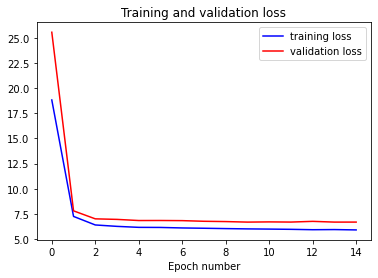

In [60]:
# Plot train and val_loss (mse)
plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation loss')
plt.legend()
plt.show() 

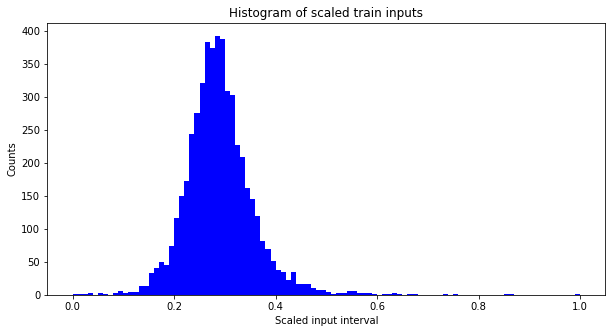

In [61]:
# Plot histogram of scaled inputs: Feature 1 (sp500 close (rel chg))
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_input_scaled[:,0,0], nBins, color="blue")
axes.set_xlabel("Scaled input interval")
axes.set_ylabel("Counts")
axes.set_title("Histogram of scaled train inputs")
plt.show()

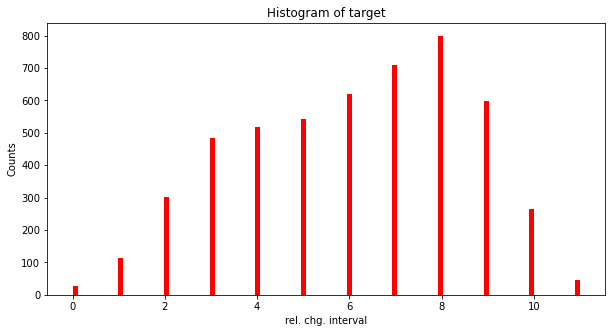

In [62]:
# Plot histogram of targets
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_target_true_pred[:,0], nBins, color="red")
axes.set_xlabel("rel. chg. interval")
axes.set_ylabel("Counts")
axes.set_title("Histogram of target")
plt.show()

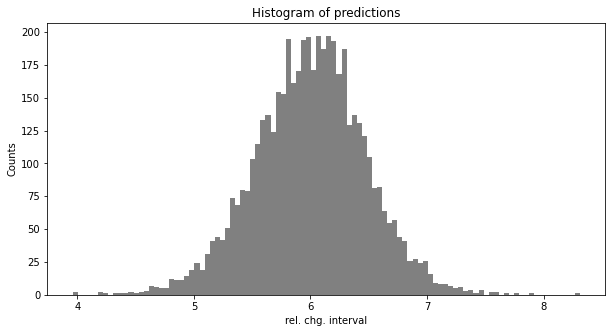

In [63]:
# Get model predictions on TRAIN inputs:
train_pred = model.predict(train_input_scaled)

# Plot histogram of predictions
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_pred[:,0], nBins, color="grey")
axes.set_xlabel("rel. chg. interval")
axes.set_ylabel("Counts")
axes.set_title("Histogram of predictions")
plt.show()

#### END Quick check

In [64]:
# Initialize storage for predictions and correct predictions.
# Desired shape: (#runs, #samples)

# NOTE: Need to be careful not to over-write above results from first multi-run experiment!
# Add prefix "high_low".
high_low_train_pred_all = np.zeros((n_runs, len(train_target)))
high_low_val_pred_all = np.zeros((n_runs, len(val_target)))
high_low_test_pred_all = np.zeros((n_runs, len(test_target)))
high_low_train_correct_pred = np.zeros((n_runs, len(train_target)))
high_low_val_correct_pred = np.zeros((n_runs, len(val_target)))
high_low_test_correct_pred = np.zeros((n_runs, len(test_target)))

# Initialize storage for models of second part:
models_part2 = []

In [65]:
# Loop over number of runs:
for n_run in range(n_runs):

    # Print status:
    print("Run: ", n_run+1, " of ", n_runs)

    # Set up compiled model:
    model = set_CNN_fc(
        CNN_filters, CNN_kernel_sizes, fc_units, fc_hidden_activation,
        n_epochs, batch_size, learning_rate, loss_function
    )

    # Train model on scaled inputs and un-scaled targets:
    history = model.fit(
        train_input_scaled, train_target_true_pred,
        epochs=n_epochs, batch_size=batch_size, 
        shuffle=True, verbose=0
    )
    
    # Store trained model:
    models_part2.append(model)

    # Get model predictions:
    train_pred = model.predict(train_input_scaled)
    val_pred = model.predict(val_input_scaled)
    test_pred = model.predict(test_input_scaled)

    # Convert to binary predictions:
    # Defined "high reliability" when 6 or more models (from 11 runs in total) agreed:
    train_pred_bin = (train_pred >= 6)
    val_pred_bin = (val_pred >= 6)
    test_pred_bin = (test_pred >= 6)

    # Store model predictions on train, validation and test data
    high_low_train_pred_all[n_run,:] = train_pred[:,0]
    high_low_val_pred_all[n_run,:] = val_pred[:,0]
    high_low_test_pred_all[n_run,:] = test_pred[:,0]  

    # Store for current run where binary predictions on train, validation and test data meet binary targets:
    high_low_train_correct_pred[n_run,:] = ((train_pred_bin == train_target_true_pred_bin).astype(int)[:,0])
    high_low_val_correct_pred[n_run,:] = (val_pred_bin == val_target_true_pred_bin).astype(int)[:,0]
    high_low_test_correct_pred[n_run,:] = (test_pred_bin == test_target_true_pred_bin).astype(int)[:,0]

Run:  1  of  11
Run:  2  of  11
Run:  3  of  11
Run:  4  of  11
Run:  5  of  11
Run:  6  of  11
Run:  7  of  11
Run:  8  of  11
Run:  9  of  11
Run:  10  of  11
Run:  11  of  11


In [238]:
### Save and reload trained models for part 2:

## Save models:

# # Loop over models from part 2:
# for model_number in range(n_runs):
#     path_to_model = '../models/part2/model_'+str(model_number+1)
#     models_part2[model_number].save(path_to_model)

## Reload trained models:

# # Initialize storage for models of part 2:
# models_part2 = []

# # Loop over models from part 2:
# for model_number in range(n_runs):
#     path_to_model = '../models/part2/model_'+str(model_number+1)
#     model = tf.keras.models.load_model(path_to_model)
#     models_part2.append(model)

INFO:tensorflow:Assets written to: ../models/part2/model_1/assets
INFO:tensorflow:Assets written to: ../models/part2/model_2/assets
INFO:tensorflow:Assets written to: ../models/part2/model_3/assets
INFO:tensorflow:Assets written to: ../models/part2/model_4/assets
INFO:tensorflow:Assets written to: ../models/part2/model_5/assets
INFO:tensorflow:Assets written to: ../models/part2/model_6/assets
INFO:tensorflow:Assets written to: ../models/part2/model_7/assets
INFO:tensorflow:Assets written to: ../models/part2/model_8/assets
INFO:tensorflow:Assets written to: ../models/part2/model_9/assets
INFO:tensorflow:Assets written to: ../models/part2/model_10/assets
INFO:tensorflow:Assets written to: ../models/part2/model_11/assets


In [28]:
### Save and reload histories:

# np.save('../results/histories_multirun_09a.npy', high_low_train_correct_pred)
# np.save('../results/histories_multirun_09b.npy', high_low_val_correct_pred)
# np.save('../results/histories_multirun_09c.npy', high_low_test_correct_pred)
# np.save('../results/histories_multirun_09d.npy', high_low_train_pred_all)
# np.save('../results/histories_multirun_09e.npy', high_low_val_pred_all)
# np.save('../results/histories_multirun_09f.npy', high_low_test_pred_all)

# high_low_train_correct_pred = np.load('../results/histories_multirun_09a.npy')
# high_low_val_correct_pred = np.load('../results/histories_multirun_09b.npy')
# high_low_test_correct_pred = np.load('../results/histories_multirun_09c.npy')
# high_low_train_pred_all = np.load('../results/histories_multirun_09d.npy')
# high_low_val_pred_all = np.load('../results/histories_multirun_09e.npy')
# high_low_test_pred_all = np.load('../results/histories_multirun_09f.npy')

## Or re-load former results for target 20d, but didn't save models!

# high_low_train_correct_pred = np.load('../results/histories_multirun_06a.npy')
# high_low_val_correct_pred = np.load('../results/histories_multirun_06b.npy')
# high_low_test_correct_pred = np.load('../results/histories_multirun_06c.npy')
# high_low_train_pred_all = np.load('../results/histories_multirun_06d.npy')
# high_low_val_pred_all = np.load('../results/histories_multirun_06e.npy')
# high_low_test_pred_all = np.load('../results/histories_multirun_06f.npy')


## Additional parameters to restore plots subsequent steps from re-loaded data:
# target_horizons = [(3,),] # 0: 1d, 1: 5d, 2: 10d, 3: 20d
# input_length = 20
# n_epochs = 15
# batch_size = 20

In [29]:
## Derive a binary prediction to classify VIX samples a HIGH / LOW reliable, according to predicted number 
# of correct predictions. HIGH: Prediction is greater or equal to 6, LOW: else.
# Note: This actually tells us, WHERE we act, according to binary ensemble predictor UP or DOWN.
# Count number of models that predicted HIGH reliability (>=5.5).
# Get majority vote: More or equal than 6 models predicting HIGH reliability, we take HIGH as ensemble prediction.
# Create binary target HIGH = 1, LOW = 0:
high_low_ensemble_train_pred_bin = (np.sum((high_low_train_pred_all >= 5.5), axis=0) >= 6).astype(int)
high_low_ensemble_val_pred_bin = (np.sum((high_low_val_pred_all >= 5.5), axis=0) >= 6).astype(int)
high_low_ensemble_test_pred_bin = (np.sum((high_low_test_pred_all >= 5.5), axis=0) >= 6).astype(int)

In [30]:
# Now check the ensemble predictor HIGH / LOW: What's the rel. amount samples predicted as HIGH reliable
# in the majority vote?
print("rel. amount of TRAIN samples with ensemble prediction HIGH reliable: ", 
      np.round(sum(high_low_ensemble_train_pred_bin)/len(high_low_ensemble_train_pred_bin),3))
print("rel. amount of VAL samples with ensemble prediction HIGH reliable: ", 
      np.round(sum(high_low_ensemble_val_pred_bin)/len(high_low_ensemble_val_pred_bin),3))
print("rel. amount of TEST samples with ensemble prediction HIGH reliable: ", 
      np.round(sum(high_low_ensemble_test_pred_bin)/len(high_low_ensemble_test_pred_bin),3))

rel. amount of TRAIN samples with ensemble prediction HIGH reliable:  0.985
rel. amount of VAL samples with ensemble prediction HIGH reliable:  0.986
rel. amount of TEST samples with ensemble prediction HIGH reliable:  0.979


In [31]:
# Get accuracy of multi-run experiment ensemble prediction:
print("train acc from multi-run experiment: ", np.round(
    sum(high_low_ensemble_train_pred_bin == train_target_true_pred_bin[:,0])
    / len(train_target_true_pred_bin),3)
)
print("val acc from multi-run experiment: ", np.round(
    sum(high_low_ensemble_val_pred_bin == val_target_true_pred_bin[:,0])
    / len(val_target_true_pred_bin),3)
)
print("test acc from multi-run experiment: ", np.round(
    sum(high_low_ensemble_test_pred_bin == test_target_true_pred_bin[:,0])
    / len(test_target_true_pred_bin),3)
)

# Compare to naive accuracy, if we predict ALL areas to be "high reliability"
print("\nnaive train acc: ", np.round(sum(train_target_true_pred_bin)/len(train_target_true_pred_bin),3)[0])
print("naive val acc: ", np.round(sum(val_target_true_pred_bin)/len(val_target_true_pred_bin),3)[0])
print("naive test acc: ", np.round(sum(test_target_true_pred_bin)/len(test_target_true_pred_bin),3)[0])

train acc from multi-run experiment:  0.622
val acc from multi-run experiment:  0.655
test acc from multi-run experiment:  0.594

naive train acc:  0.618
naive val acc:  0.66
naive test acc:  0.603


#### Check FULL model's (out-)performance

In [32]:
# Get "naive" performance, when - for simplicity - we just add target performance (20d horizon):
print("naive train performance: ", np.round(sum(train_target[:,0])*100,1), "%")
print("naive val performance: ", np.round(sum(val_target[:,0])*100,1), "%")
print("naive test performance: ", np.round(sum(test_target[:,0])*100,1), "%")

naive train performance:  2974.4 %
naive val performance:  2311.2 %
naive test performance:  576.7 %


In [33]:
# Get model performance, if we only act on HIGH reliability samples and then ALWAYS get LONG:
print("train performance: ", np.round(sum(high_low_ensemble_train_pred_bin*train_target[:,0])*100,1), "%")
print("val performance: ", np.round(sum(high_low_ensemble_val_pred_bin*val_target[:,0])*100,1), "%")
print("test performance: ", np.round(sum(high_low_ensemble_test_pred_bin*test_target[:,0])*100,1), "%")

train performance:  3167.3 %
val performance:  2294.2 %
test performance:  580.4 %


In [34]:
# Get model performance, we only act on HIGH reliability samples, as predicted by part 2 ensemble.
# And then act according to majority vote (UP / DOWN) from part 1 ensemble:
print("train performance: ", np.round((sum((ensemble_train_pred_bin==1).astype(int)*high_low_ensemble_train_pred_bin*train_target[:,0]) +
                                       sum((ensemble_train_pred_bin==0).astype(int)*high_low_ensemble_train_pred_bin*(-train_target[:,0])))*100,1), "%")
print("val performance: ", np.round((sum((ensemble_val_pred_bin==1).astype(int)*high_low_ensemble_val_pred_bin*val_target[:,0]) +
                                       sum((ensemble_val_pred_bin==0).astype(int)*high_low_ensemble_val_pred_bin*(-val_target[:,0])))*100,1), "%")
print("test performance: ", np.round((sum((ensemble_test_pred_bin==1).astype(int)*high_low_ensemble_test_pred_bin*test_target[:,0]) +
                                       sum((ensemble_test_pred_bin==0).astype(int)*high_low_ensemble_test_pred_bin*(-test_target[:,0])))*100,1), "%")

train performance:  4654.1 %
val performance:  2124.6 %
test performance:  63.0 %


In [41]:
# Get model performance, we act on HIGH reliability samples, as predicted by part 2 ensemble.
# And then act according to majority vote (UP / DOWN) from part 1 ensemble.
# And - in addition to that - we act on LOW reliability samples, but act oppositely to the majority vote (UP / DOWN):
print("train performance: ", np.round((sum((ensemble_train_pred_bin==1).astype(int)*high_low_ensemble_train_pred_bin*train_target[:,0]) +
                                       sum((ensemble_train_pred_bin==0).astype(int)*high_low_ensemble_train_pred_bin*(-train_target[:,0]))+
                                      (sum((ensemble_train_pred_bin==1).astype(int)*(high_low_ensemble_train_pred_bin==0).astype(int)*(-train_target[:,0])) +
                                       sum((ensemble_train_pred_bin==0).astype(int)*(high_low_ensemble_train_pred_bin==0)*train_target[:,0])))*100,1), "%")
print("val performance: ", np.round((sum((ensemble_val_pred_bin==1).astype(int)*high_low_ensemble_val_pred_bin*val_target[:,0]) +
                                       sum((ensemble_val_pred_bin==0).astype(int)*high_low_ensemble_val_pred_bin*(-val_target[:,0]))+
                                    (sum((ensemble_val_pred_bin==1).astype(int)*(high_low_ensemble_val_pred_bin==0).astype(int)*(-val_target[:,0])) +
                                       sum((ensemble_val_pred_bin==0).astype(int)*(high_low_ensemble_val_pred_bin==0)*val_target[:,0])))*100,1), "%")
print("test performance: ", np.round((sum((ensemble_test_pred_bin==1).astype(int)*high_low_ensemble_test_pred_bin*test_target[:,0]) +
                                       sum((ensemble_test_pred_bin==0).astype(int)*high_low_ensemble_test_pred_bin*(-test_target[:,0]))+
                                     (sum((ensemble_test_pred_bin==1).astype(int)*(high_low_ensemble_test_pred_bin==0).astype(int)*(-test_target[:,0])) +
                                       sum((ensemble_test_pred_bin==0).astype(int)*(high_low_ensemble_test_pred_bin==0)*test_target[:,0])))*100,1), "%")

train performance:  4777.3 %
val performance:  2116.3 %
test performance:  66.7 %


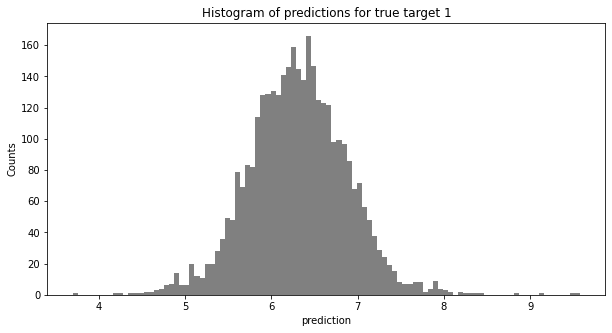

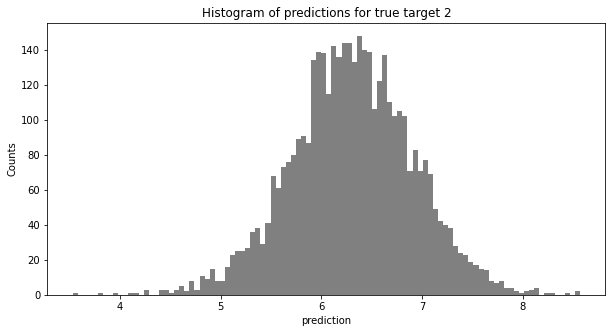

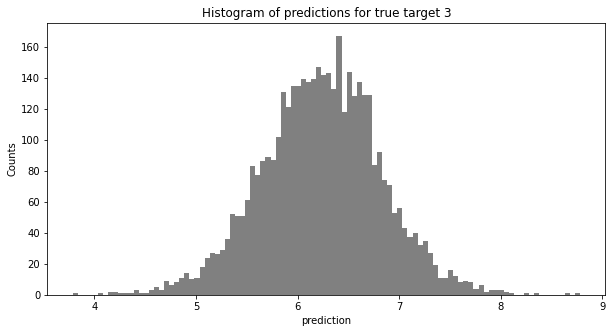

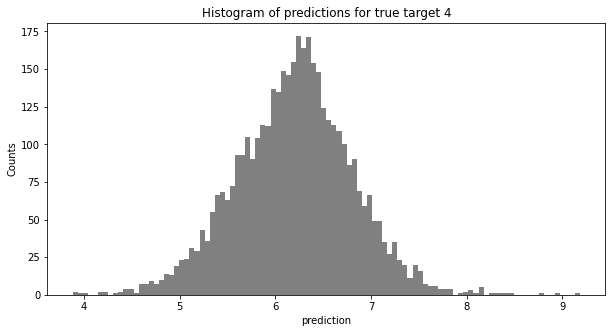

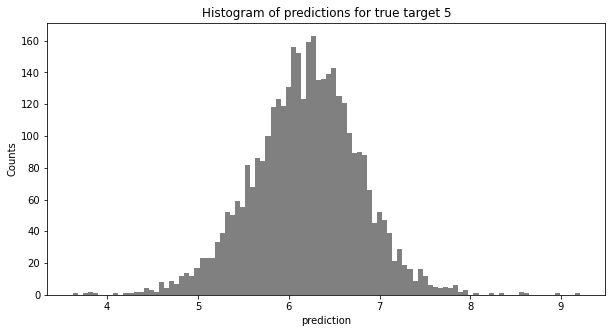

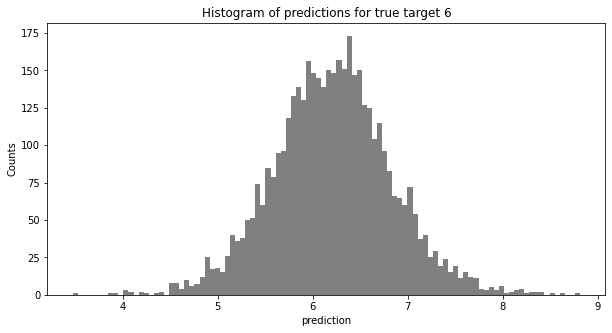

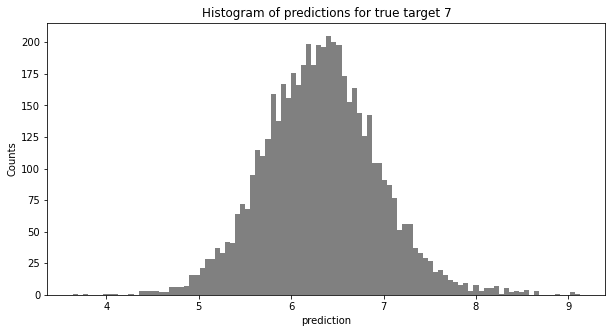

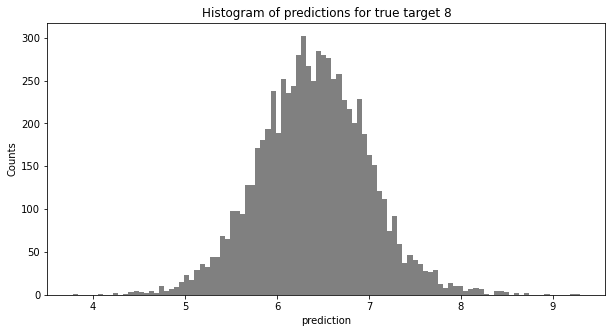

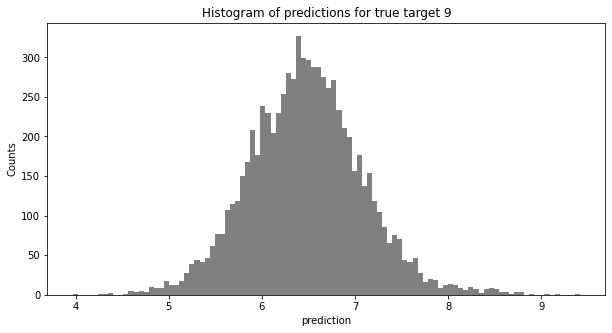

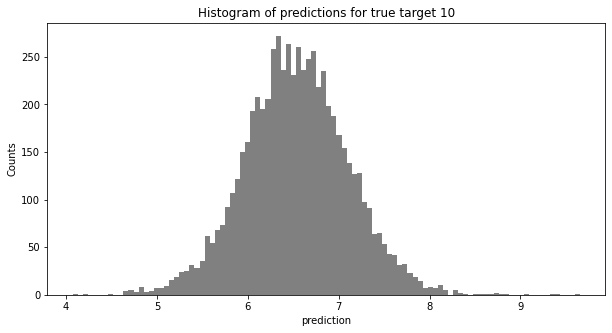

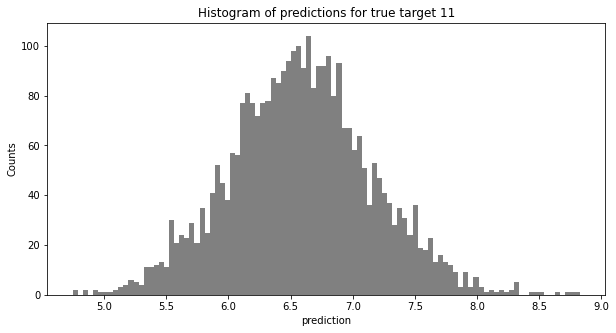

In [77]:
# So far we act, whenever at least 6 models (of part 2) agree on HIGH reliability. Find poor performance on
# validation and especially on train data.
# Tried to be more picky and act only, if at least 7 (or 8 / 9 / 10 / 11) models agree: Still poor or even worse
# performance.

# Now check for a given target ("number of models with correct prediction" (part 1)) the distribution of predictions
# from all predictions of part 2 models (high_low_train_pred_all):

# Loop over targets (= number of models with correct prediction):
for i in range(n_runs):
    
    temp_hist = high_low_train_pred_all[:, train_target_true_pred[:,0]==i+1].flatten()

    # Plot histogram of predictions
    nBins = 100
    fig, axes = plt.subplots(1, 1, figsize=(10,5))
    axes.hist(temp_hist, nBins, color="grey")
    axes.set_xlabel("prediction")
    axes.set_ylabel("Counts")
    axes.set_title("Histogram of predictions for true target " + str(i+1))
    plt.show()

### Next steps and final discussion

This TWO-STEP approach obviously failed! Stick to the *old* gameplan and add additional features.